In [1]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values

In [6]:
def oifits_to_pandas(filename, inst_name):
    # Reads in an oifits file and converts into a pandas dataframe with the necessary information needed for RADPy
    # Extracts the following data:
    #   V2, dv2, ucoord, vcoord, mjd, time, effective wavelength, and effective bandwidth
    # Converts the wavelengths and bandwidth arrays into lists of lists to match the V2 and V2err lists
    # creates a dataframe
    # Sorts the dataframe by MJD and then assigns a bracket number based on the date groupings
    # Explodes the dataframe by extracting out each list for V2, V2_err, wavelength, and bandwidth
    # returns the exploded, sorted, and bracket labeled df

    data = fits.open(filename)
    v2 = data["OI_VIS2"].data["VIS2DATA"]
    dv2 = data["OI_VIS2"].data["VIS2ERR"]
    ucoord = data["OI_VIS2"].data["UCOORD"]
    vcoord = data["OI_VIS2"].data["VCOORD"]
    mjd = data["OI_VIS2"].data["MJD"]
    time = data["OI_VIS2"].data["TIME"]
    wl = data["OI_WAVELENGTH"].data["EFF_WAVE"]
    band = data["OI_WAVELENGTH"].data["EFF_BAND"]

    wl_list = [wl.tolist() for _ in range(len(v2))]
    band_list = [band.tolist() for _ in range(len(v2))]

    pd.set_option('display.float_format', '{:.12f}'.format)
    df = pd.DataFrame({'MJD': mjd, 'Time': time, 'V2': v2.tolist(), 'V2_err': dv2.tolist(),
                       'Eff_wave[m]': wl_list, 'Eff_band[m]': band_list, 'UCOORD[m]': ucoord, 'VCOORD[m]': vcoord})

    sorted_df = brackets(df, inst_name)
    # sorted_df = df.sort_values(by = 'MJD')
    # sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup()+1

    sorted_df['zipped'] = sorted_df.apply(
        lambda row: list(zip(row['V2'], row['V2_err'], row['Eff_wave[m]'], row['Eff_band[m]'])), axis=1)
    df_exploded = sorted_df.explode('zipped').reset_index(drop=True)
    df_exploded[['V2', 'V2_err', 'Eff_wave[m]', 'Eff_band[m]']] = pd.DataFrame(df_exploded['zipped'].tolist(),
                                                                               index=df_exploded.index)
    df_exploded = df_exploded.drop(columns='zipped')
    df_exploded['Instrument'] = [inst_name] * len(df_exploded)

    return df_exploded
def brackets(df, instrument):
    # bracket generator
    # PAVO brackets are assigned via same baseline
    # Classic has no brackets
    # MIRCX/MYSTIC/SPICA are by MJD
    # Vega is uncertain for now but will be date im fairly certain
    if instrument == 'M' or instrument == 'm':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df
    if instrument == 'P' or instrument == 'p':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='U(meters)')
        sorted_df['Bracket'] = sorted_df.groupby('U(meters)').ngroup() + 1
        return sorted_df
    if instrument == 'C' or instrument == 'c':
        pd.set_option('display.float_format', '{:.12f}'.format)
        df['Bracket'] = [1] * len(df)
        return df
    if instrument == 'S' or instrument == 's':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='UCOORD[m]')
        sorted_df['Bracket'] = sorted_df.groupby('UCOORD[m]').ngroup() + 1
        return sorted_df
    if instrument == 'My' or instrument == 'my':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df
    if instrument == 'V' or instrument == 'v':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df

In [7]:
def filename_extension(filename, inst_name, verbose=False, debug = False):
    #########################################################################
    # Function: filename_extension                                          #
    # Inputs: filename -> name of data file                                 #
    #         inst_name -> Instrument identifier                            #
    #                      C - Classic                                      #
    #                      P - PAVO                                         #
    #                      V - VEGA                                         #
    #                      M - MIRCX                                        #
    #                      MY - MYSTIC                                      #
    #                      S - SPICA                                        #
    #         verbose -> default is False, if true, allows print statements #
    # Outputs: data frame of the data with the instrument added as a column #
    # What it does:                                                         #
    #         1. Checks what format the file is in                          #
    #         If .csv:                                                      #
    #            2a. Uses pandas.read_csv to read in the file               #
    #            3a. Adds the Instrument column                             #
    #         If .txt:                                                      #
    #            2b. Opens the file and reads in the first line             #
    #            3b. Checks what delimiter the file is using                #
    #            4b. Reads in the file                                      #
    #            5b. Adds the instrument column                             #
    #         If .oifits or .fits:                                          #
    #            2c. uses the oifits_to_pandas function                     #
    #         Returns the dataframe, and number of brackets                 #
    #########################################################################

    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets
        # return sorted_df
    elif filename.endswith('.txt'):
        header = None
        data_start = 0
        with open(filename, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
                if debug:
                    print(f"Header detected: {header}")
                break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets


    elif filename.endswith('.oifits') or filename.endswith('.fits'):
        df = oifits_to_pandas(filename, inst_name)
        num_brackets = df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return df, num_brackets
        # return df

    else:
        header = None
        data_start = 0
        with open(filename, "r") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
            if debug:
                print(f"Header detected: {header}")
            break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets


In [8]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\Vegadata.csv"
filenamem = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MIRCX_June11162025_HD_219134.oifits"
filenamemy = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MYSTIC_June11612025_HD_219134.oifits"
filenames = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\SPICA_01_2025-06-11T11-16-21_HD_219134_L2.fits"

In [9]:
datav, num_brack_v = filename_extension(filenamev, 'V')
datac, num_brack_c = filename_extension(filenamec, 'C')
datap, num_brack_p = filename_extension(filenamep, 'P')
datam, num_brack_m = filename_extension(filenamem, 'M')
datas, num_brack_s = filename_extension(filenames, 'S')
datamy, num_brack_my = filename_extension(filenamemy, 'My')

Number of brackets: 20
Number of brackets: 1
Number of brackets: 17
Number of brackets: 18
Number of brackets: 15
Number of brackets: 30


In [10]:
datamy

,MJD,Time,V2,V2_err,Eff_wave[m],Eff_band[m],UCOORD[m],VCOORD[m],Bracket,Instrument
0,60837.461743277927,39894.619216024876,0.668750964549,0.153559849840,0.000002392452,0.000000007531,12.514891831265,168.342651846445,1,My
1,60837.461743277927,39894.619216024876,0.656575131169,0.109688726659,0.000002384858,0.000000007531,12.514891831265,168.342651846445,1,My
2,60837.461743277927,39894.619216024876,0.694847882592,0.112136924113,0.000002377266,0.000000007531,12.514891831265,168.342651846445,1,My
3,60837.461743277927,39894.619216024876,0.684410311306,0.094001335001,0.000002369675,0.000000007531,12.514891831265,168.342651846445,1,My
4,60837.461743277927,39894.619216024876,0.669628983034,0.084556776784,0.000002362086,0.000000007531,12.514891831265,168.342651846445,1,My
...,...,...,...,...,...,...,...,...,...,...
2291,60837.476761332822,41192.179146409035,0.308145174122,0.047393746062,0.000002007149,0.000000007531,-146.205918843330,-191.611671621084,30,My
2292,60837.476761332822,41192.179146409035,0.282333267072,0.063171190873,0.000001999634,0.000000007531,-146.205918843330,-191.611671621084,30,My
2293,60837.476761332822,41192.179146409035,0.294331612624,0.062239186434,0.000001992121,0.000000007531,-146.205918843330,-191.611671621084,30,My
2294,60837.476761332822,41192.179146409035,0.340657123850,0.081215388301,0.000001984610,0.000000007531,-146.205918843330,-191.611671621084,30,My


In [12]:
pavo_data = PavoData(datap)
vega_data = VegaData(datav)
classic_data = ClassicData(datac)
mircx_data = MircxData(datam)
mystic_data = MysticData(datamy)
spica_data = SpicaData(datas)

In [13]:
df_m = mircx_data.make_df()
df_my = mystic_data.make_df()
df_p = pavo_data.make_df()
df_v = vega_data.make_df()
df_c = classic_data.make_df()
df_s = spica_data.make_df()

In [ ]:
df_m

In [14]:
b, v2, dv2, wave, band, brack, inst = combined(df_p, df_c, df_v, df_m,df_my, df_s)
spf = b/wave

In [15]:
star = StellarParams()
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

In [16]:
D, dD = distances('HD 219134', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3 ID: Gaia DR3 2009481748875806976
Corrected parallax: 152.83842 [mas]
Distance: 6.54286 +/- 0.00212 [pc]


C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


In [17]:
theta1, dtheta1, chisqr1 = initial_UDfit(spf, v2, dv2, 0.4, star, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 3660
    # variables        = 1
    chi-square         = 5290.82238
    reduced chi-square = 1.44597496
    Akaike info crit   = 1350.74860
    Bayesian info crit = 1356.95382
    R-squared          = -9.85070044
[[Variables]]
    theta:  1.06097079 +/- 8.2701e-04 (0.08%) (init = 0.4)


In [18]:
theta2, dtheta2, chisqr2 = initial_LDfit(spf, v2, dv2, star, 'R', verbose = True)

Effective temperature: 4908.17082 +/- 33.0575 K
LDC for filter  R : 0.67269
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 3660
    # variables        = 1
    chi-square         = 5098.74459
    reduced chi-square = 1.39348035
    Akaike info crit   = 1215.40421
    Bayesian info crit = 1221.60942
    R-squared          = -9.45677708
[[Variables]]
    theta:  1.13657737 +/- 8.9596e-04 (0.08%) (init = 1.06097)


In [20]:
results = run_UDfit(10, 10, datasets = [pavo_data, vega_data, classic_data, mircx_data,mystic_data, spica_data], stellar_params = star)

In [21]:
udfit_values(spf, v2, dv2, results, stellar_params = star, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0591 +/- 0.00787 mas
Chi-squared: 8192.861
Chi-squared reduced: 2.239
Temperature: 4912.4 +/- 37.7 K


In [22]:
thetaf, dthetaf, tf, dtf, ldcsf, chisf = run_LDfit(2, 2, ogdata = [spf, v2, dv2], datasets = [pavo_data, vega_data, classic_data, mircx_data, mystic_data, spica_data], stellar_params = star, verbose = True)

Final Values after  11  iterations:
Limb-darkened Disk Diameter after MC/BS: 1.1085 +/- 0.00516 mas
Limb-darkening coefficient in R: 0.68333
Chi-squared for R band: 6240.554
Reduced chi-squared for R band: 1.706
Limb-darkening coefficient in K: 0.32169
Chi-squared for K band: 5592.284
Reduced chi-squared for K band: 1.528
Limb-darkening coefficient in H: 0.37447
Chi-squared for H band: 5360.191
Reduced chi-squared for H band: 1.465
Temperature: 4801.8 +/- 34.2 K
Percent difference: 0.01 %
Percent difference: 0.02 %


In [23]:
calc_star_params(star, verbose = True)

Linear Radius:  0.781 +/- 0.004 [R_solar]
Luminosity:  0.291 +/- 0.008 [L_solar]
Effective temperature:  4801.836 +/- 34.166 [K]


In [25]:
data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data, 'mircx':mircx_data,'mystic':mystic_data, 'spica':spica_data}


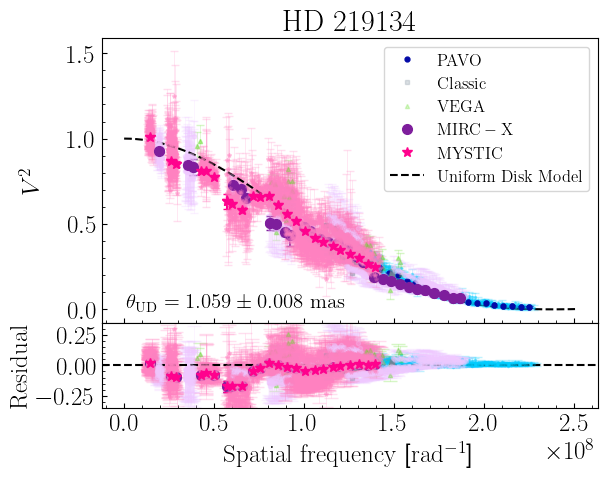

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [32]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['pavo', 'classic', 'vega', 'mircx', 'mystic'],
    to_bin = ['mystic', 'mircx', 'pavo'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['mircx'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

In [ ]:
datas

In [ ]:
ucoord = datas['UCOORD[m]']
vcoord = datas['VCOORD[m]']
v2 = datas['V2']
wave = datas['Eff_wave[m]']
import numpy as np
base = np.sqrt(ucoord**2 + vcoord**2)
spf = base/wave

In [ ]:
pip list

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.close()
plt.plot(df_m['B']/df_m['Wave'], df_m['V2'], '.', label = 'MIRCX')
plt.plot(df_p['B']/df_p['Wave'], df_p['V2'], '.', label = 'PAVO')
plt.plot(df_c['B']/df_c['Wave'], df_c['V2'], '.', label = 'Classic')
plt.plot(df_v['B']/df_v['Wave'], df_v['V2'], '.', label = 'VEGA')
plt.plot(df_s['B']/df_s['Wave'], df_s['V2'], '.', label = 'SPICA')
plt.legend()
plt.show()

In [ ]:
datas = oifits_to_pandas(filenames, 'S')

In [ ]:
ucoord = datas['UCOORD[m]']
vcoord = datas['VCOORD[m]']
v2 = datas['V2']
wave = datas['Eff_wave[m]']
import numpy as np
base = np.sqrt(ucoord**2 + vcoord**2)
spf = base/wave

In [ ]:
plt.plot(spf, v2, '.')